In [ ]:
import os, itertools, time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'figure.figsize': (40, 8), 'font.family': 'serif', 'text.usetex': False, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2

import jax
jax.config.update('jax_platform_name', 'cpu')

from smolyax import indices, nodes
from smolyax.interpolation import SmolyakBarycentricInterpolator

def target_f(x, theta, r) :
    return 1/(1+ theta * np.sum(x * (np.arange(x.shape[-1]) + 2)**(-r), axis=-1))

r, theta = 2., .1
f = lambda x : target_f(x, theta, r)

# `SmolyakBarycentricInterpolator` runtime

Runtime is a key performance metric for interpolation methods. This notebook empirically sketches how runtime of key algorithm components (mainly setup time and evalutation time) develops in dependence of the dimensionality of the input domain and the number of interpolation points.

In [20]:
dimensions = [10,1000]
batchsize = 250
m_max = 10_000
n_tests = 10

cost_setup = np.zeros((len(dimensions), n_tests))
cost_eval = np.zeros((len(dimensions), n_tests))
ns = np.zeros((len(dimensions), n_tests))

for i, d in enumerate(dimensions) :
    node_gen = nodes.Leja(dim=d)
    k  = [np.log((ki+2)**(r)/theta) for ki in range(d)]
    max_t = indices.find_approximate_threshold(k, m_max, node_gen.is_nested)

    for j, t in enumerate(np.linspace(2, max_t, n_tests)) : 
        
        # measure setup time
        t_start = time.time()
        ip = SmolyakBarycentricInterpolator(node_gen=node_gen, k=k, t=t, d_out=1, f=f, batchsize=batchsize)
        cost_setup[i,j] = time.time() - t_start
        ns[i,j] = ip.n_f_evals

        # measure eval time
        x = node_gen.get_random(batchsize)
        t_start = time.time()
        y = ip(x)
        cost_eval[i,j] = time.time() - t_start

## 1. Setup time

The plot below shows the dependence of setup time on the number of interpolation nodes $m$, for varying dimension $d$ of the input domain on which to interpolate.

The setup time includes generating the multi-index set and the interpolation nodes and weights, allocating the necessary data structures, calling the (in this case, simplistic) target function at the interpolation nodes, as well as a sample evaluation to trigger jit-compilation. 

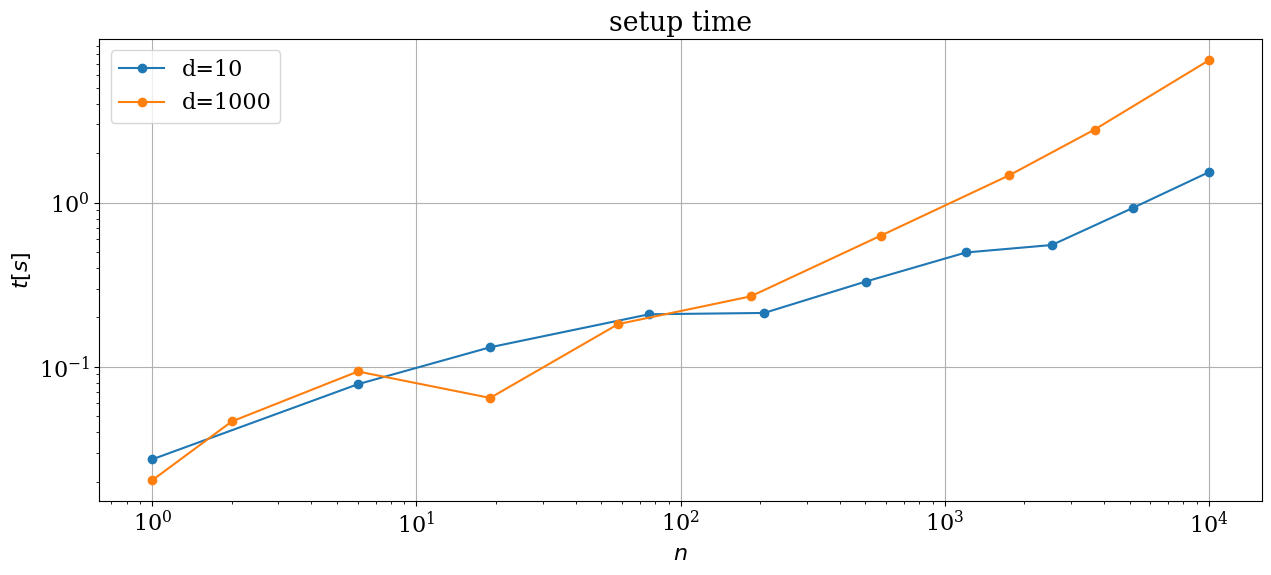

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
for i, d in enumerate(dimensions) :
    ax.loglog(ns[i], cost_setup[i], marker='o', label=rf'd={d}')
ax.set_xlabel(r'$n$'); ax.set_ylabel(r'$t [s]$'); ax.grid(); ax.legend(); ax.set_title(rf'setup time'); 

## 2. Evaluation time 

Following the same setup as in 1., we here show the runtime of evaluating the interpolant on a batch of size $b = 250$.

**Note:** Maybe counterintuitively at first sight, the curve for $d=1000$ runs mostly below the curve for $d=10$. This could be caused by the fact that for a fixed number of interpolation nodes $m$, in higher dimensions the nodes are more distributed and the maximal number of nodes in each dimension is lower. This leads to potentially more but smaller tensors than in lower dimensions.

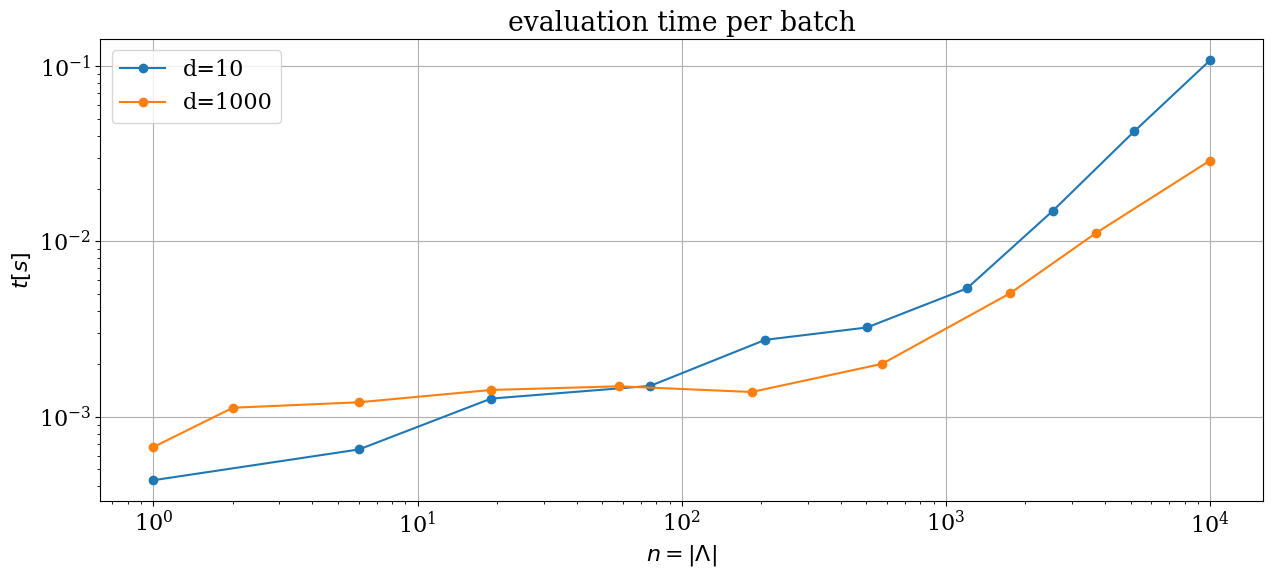

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
for i, d in enumerate(dimensions) :
    ax.loglog(ns[i], cost_eval[i], marker='o', label=rf'd={d}')
ax.set_xlabel(r'$n = |\Lambda|$'); ax.set_ylabel(r'$t [s]$'); ax.grid(); ax.legend(); ax.set_title(rf'evaluation time per batch'); 

## 3. Dependence of evaluation time per sample on the batch size

Here, we keep the number of interpolation nodes fixed at $m = 5000$ and study how the time for evaluating the interpolant at a single input sample depends on the size of the input batch.

We observe that computational overhead affects small batch sizes, with the time-per-sample then stabilizing for batch sizes in the order of $10^2$ to $10^3$.

In [ ]:
dimensions = [10,1000]
batchsizes = [1,10,100,1000,10_000]
n_max = 5000

cost_eval = np.zeros((len(dimensions), len(batchsizes)))
ns = np.zeros((len(dimensions), len(batchsizes)))

for i, d in enumerate(dimensions) :
    node_gen = nodes.Leja(dim=d)
    k = [np.log((ki+2)**(r)/theta) for ki in range(d)]
    t = indices.find_approximate_threshold(k, n_max, node_gen.is_nested)
    
    for j, b in enumerate(batchsizes) :
        ip = SmolyakBarycentricInterpolator(node_gen=node_gen, k=k, t=t, d_out=1, f=f, batchsize=b)
        x = node_gen.get_random(b)
        t_start = time.time()
        y = ip(x)
        cost_eval[i,j] = (time.time() - t_start) / b

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
for i, d in enumerate(dimensions) :
    ax.loglog(batchsizes, cost_eval[i], marker='o', label=rf'd={d}')
ax.set_xlabel(r'batchsize'); ax.set_ylabel(r'$t [s]$'); ax.grid(); ax.legend(); ax.set_title(rf'evaluation time per sample');